In [1]:
"""
clone and install PySDM dependencies in Colab
"""
import os, sys
if 'google.colab' in sys.modules:
    %cd /content
    if not os.path.isdir('PySDM'):
        !git clone --depth 1 https://github.com/atmos-cloud-sim-uj/PySDM.git
        %cd PySDM
    else:
        %cd PySDM
        !git pull
    !pip install -r requirements.txt
    !ldconfig

In [2]:
import os, sys
if 'google.colab' in sys.modules:
    %cd /content/PySDM
else:
    sys.path.insert(0, os.path.join(os.getcwd(), '../..'))

In [3]:
from PySDM_examples.Arabas_et_al_2015_Figs_8_9.settings import Settings
from PySDM_examples.Arabas_et_al_2015_Figs_8_9.simulation import Simulation
from PySDM_examples.Arabas_et_al_2015_Figs_8_9.storage import Storage
from PySDM_examples.Arabas_et_al_2015_Figs_8_9.netcdf_exporter import NetCDFExporter
from PySDM_examples.Arabas_et_al_2015_Figs_8_9.demo_plots import _TimeseriesPlot, _ImagePlot

from PySDM_examples.utils.temporary_file import TemporaryFile
from PySDM_examples.utils.show_plot import show_plot
from PySDM_examples.utils.widgets import display, HTML, FloatProgress
import PySDM.products as PySDM_products
from PySDM.physics import si

import numpy as np
from scipy.io.netcdf import netcdf_file
from matplotlib import pyplot, rcParams
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
import logging

/home/slayoo/devel/PySDM/PySDM_examples/Bartman_et_al_2021/../../PySDM/backends/__init__.py:29: UserWarning: CUDA library found but cuInit() failed (error code: 999; message: unknown error)
  warnings.warn(


In [4]:
class ProgBarController:
    def __init__(self):
        self.progress = FloatProgress(value=0.0, min=0.0, max=1.0)
        self.panic = False
        self.logger = logging.getLogger('...')
        self.logger.setLevel(logging.INFO)

    def __enter__(self):
        self.set_percent(0)
        display(self.progress)
        self.logger.info("start")
        
    def __exit__(self, *_):
        self.logger.info("stop")
    
    def set_percent(self, value):
        self.progress.value = value

In [49]:
runs = (
    {'file': TemporaryFile('.nc'), 'settings': {}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_substeps':   16, 'condensation_adaptive': False}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_substeps':   32, 'condensation_adaptive': False}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_substeps':   64, 'condensation_adaptive': False}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_substeps':  128, 'condensation_adaptive': False}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_substeps':  256, 'condensation_adaptive': False}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_substeps':  512, 'condensation_adaptive': False}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_substeps': 1024, 'condensation_adaptive': False}},
)

In [50]:
for run in runs:
    settings = Settings()

    products = (
        PySDM_products.AerosolSpecificConcentration(radius_threshold=settings.aerosol_radius_threshold),
        PySDM_products.ParticleMeanRadius(),
        PySDM_products.DrizzleConcentration(radius_threshold=settings.drizzle_radius_threshold),
        PySDM_products.PeakSupersaturation(),
        PySDM_products.WallTime()
    )

    settings.n_sd_per_gridbox = 32
    settings.grid = (64, 64)
    settings.dt = 16 * si.s
#     settings.mode_1.norm_factor *= 10
#     settings.mode_2.norm_factor *= 10
#     settings.spectrum_per_mass_of_dry_air.norm_factor *= 10
    settings.simulation_time = .2 * settings.spin_up_time
    settings.output_interval = 1 * si.minute
    settings.condensation_rtol_x = 1e-5  # TODO #419: needed to avoid timeout on Travis, revisit
    settings.condensation_rtol_thd = 1e-7
    settings.dt_cond_range = (settings.dt/1024, settings.dt)
    for key, value in run['settings'].items():        
        assert hasattr(settings, key)
        setattr(settings, key, value)
    
    storage = Storage()
    simulation = Simulation(settings, storage)
    simulation.reinit(products)

    simulation.run(ProgBarController())
    exporter = NetCDFExporter(storage, settings, simulation, run['file'].absolute_path)
    exporter.run(ProgBarController())

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

FloatProgress(value=0.0, max=1.0)

In [7]:
default_figsize = rcParams["figure.figsize"]
figsize = (2.2 * default_figsize[0], 1.3* default_figsize[1])
gs = GridSpec(nrows=9, ncols=27)

fig = pyplot.figure(figsize=figsize)
axs = (
    fig.add_subplot(gs[:gs.nrows-4, 1:gs.ncols//3-1]),
    fig.add_subplot(gs[:gs.nrows-4, gs.ncols//3+1:2*gs.ncols//3-1]),
    fig.add_subplot(gs[:gs.nrows-4, 2*gs.ncols//3+1:-1]),
    fig.add_subplot(gs[gs.nrows-3:-1,2:-1])
)
gs.tight_layout(fig)
ncdf = netcdf_file(runs[0]['file'].absolute_path, mode='r', mmap=False)

# TODO #419: we should not use products here - all info should be obtained from netCDF
plots = (
    _ImagePlot(fig, axs[0], grid=ncdf.grid, size=ncdf.size, product=products[0], cmap='summer'),
    _ImagePlot(fig, axs[1], grid=ncdf.grid, size=ncdf.size, product=products[1], cmap='PuBuGn'),
    _ImagePlot(fig, axs[2], grid=ncdf.grid, size=ncdf.size, product=products[2], cmap='Blues'),
    _TimeseriesPlot(fig, axs[3], ncdf.variables['T'][:], show=False)
)

plots[3].ax.axvline(ncdf.n_spin_up * ncdf.dt)
plots[3].ax.set_ylim(0, .001)

interval = 100 #ms
frame_list = np.arange(ncdf.variables['T'].shape[0], dtype=np.int)

def update(frame_num):
    step = frame_num * ncdf.steps_per_output_interval
    plots[0].update(ncdf.variables['n_a_mg'][frame_num], step=step)
    plots[1].update(ncdf.variables['radius_m1'][frame_num], step=step)
    plots[2].update(ncdf.variables['n_d_cm3'][frame_num], step=step)
    precip = np.full_like(ncdf.variables['surf_precip'][:], np.nan)
    precip[0:frame_num+1] = ncdf.variables['surf_precip'][0:frame_num+1]
    plots[3].update(precip)
    return (plots[0].im, plots[1].im, plots[2].im, plots[3].timeseries)
pyplot.close(fig)

In [8]:
animation = FuncAnimation(fig, update, frames=frame_list, interval=interval, blit=False)

if 'CI' not in os.environ:
    display(HTML(animation.to_html5_video()))
    file = TemporaryFile('.gif')
    animation.save(file.absolute_path)
    display(file.make_link_widget())

HTML(value='<video width="950" height="374" controls autoplay loop>\n  <source type="video/mp4" src="data:vide…

HTML(value="<a href='../utils/temporary_files/tmpv5zw81x4.gif' target='_blank'>../utils/temporary_files/tmpv5z…

In [9]:
# save last frame in vector format
svg_file = TemporaryFile('.svg')
fig.savefig(svg_file.absolute_path)
display(svg_file.make_link_widget())

HTML(value="<a href='../utils/temporary_files/tmp75yz7j2r.svg' target='_blank'>../utils/temporary_files/tmp75y…

In [51]:
def label(settings):
    return str(settings)

0.015625 16.0
0.25 0.25
0.125 0.125
0.0625 0.0625
0.03125 0.03125
0.015625 0.015625


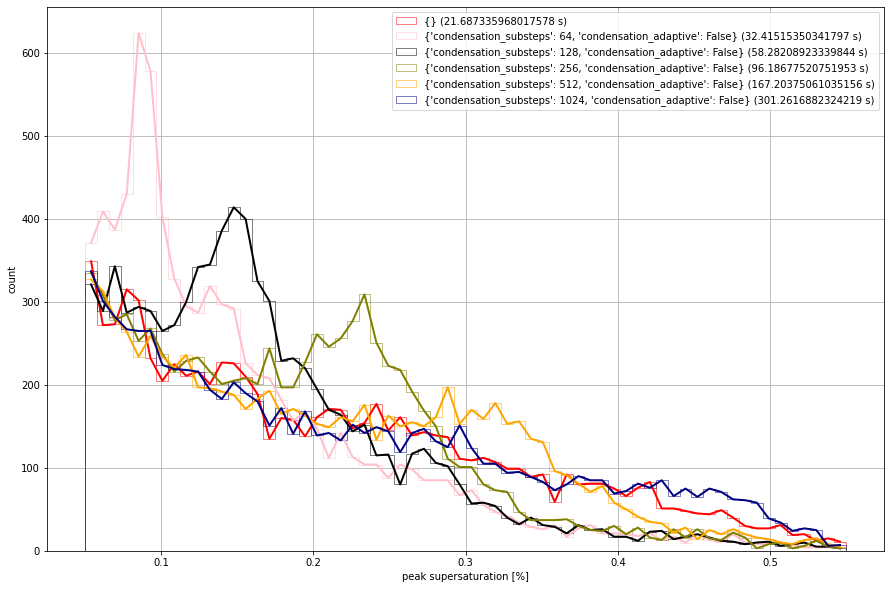

HTML(value="<a href='../utils/temporary_files/tmpa0mlmsx0.pdf' target='_blank'>../utils/temporary_files/tmpa0m…

In [94]:
from matplotlib import rcParams
rcParams["figure.figsize"] = (15,10)

colors = ('red', 'green', 'blue', 'pink', 'black', 'olive', 'orange', 'navy')

for i, run in enumerate(runs):
    if 0 < i < 3: continue
    nc = netcdf_file(run['file'].absolute_path, mode='r', mmap=False)
    n_spinup = nc.n_spin_up // nc.steps_per_output_interval
    data = nc.variables['S_max']
    timesteps = slice(2, -1)
    
    print(np.amin(nc.variables['dt_cond_min'][timesteps]), np.amax(nc.variables['dt_cond_max'][timesteps]))
    
    data = data[timesteps, :, :].flatten()
    wall_time = np.sum(nc.variables['wall_time'][timesteps])
    y, x, _ = pyplot.hist(data, bins=64, range=(.05,0.55), histtype='step', 
                          label=f"{label(run['settings'])} ({wall_time} s)", color=colors[i], lw=.5)
    pyplot.plot((x[1:] + x[:-1])/2, y, color=colors[i], lw=2)
    pyplot.ylabel('count')
    pyplot.xlabel('peak supersaturation [%]')
pyplot.grid()
pyplot.legend()
# pyplot.yscale('log')
show_plot()

In [12]:
# TODO (ideas):
# - N_activated vs. dt (+adapt)
# - rainfall vs. dt (+adapt)
# - multiple realisations spread
# - wall time with and w/o rng_reuse
# - dt coal vs. initialisation method (random, iso-multiplicity, ...)